In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from datetime import datetime
from wolta.data_tools import unique_amounts

In [2]:
card_transactions = pd.read_csv('credit_card_transactions.csv')
df = card_transactions.copy()
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [3]:
df = df.drop(columns=['Unnamed: 0', 'city_pop','zip', 'trans_num', 'street', \
                      'unix_time', 'merch_zipcode', 'cc_num'])
df.head()

,trans_date_trans_time,merchant,category,amt,first,last,gender,city,state,lat,long,job,dob,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,Moravian Falls,NC,36.0788,-81.1781,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,Orient,WA,48.8878,-118.2105,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,Malad City,ID,42.1808,-112.2620,Nature conservation officer,1962-01-19,43.150704,-112.154481,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,Boulder,MT,46.2306,-112.1138,Patent attorney,1967-01-12,47.034331,-112.561071,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,Doe Hill,VA,38.4207,-79.4629,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0


In [4]:
# Create Columns related of time
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.day
df['hour'] = df['trans_date_trans_time'].dt.hour
df['season'] = df['month'] % 12 // 3 + 1  # 1: Spring, 2: Summer, 3: Fall, 4: Winter
df['day_name'] = df['trans_date_trans_time'].dt.day_name()

In [5]:
season_mapping = {
    1: 'Spring',
    2: 'Summer',
    3: 'Fall',
    4: 'Winter'
}

In [6]:
df['season'] = df['season'].map(season_mapping)
df[['first', 'year', 'month', 'season', 'day', 'day_name', 'hour']].sample(5)

,first,year,month,season,day,day_name,hour
924470,Margaret,2019,12,Spring,31,Tuesday,21
861452,Paula,2019,12,Spring,17,Tuesday,18
276189,Brianna,2019,5,Summer,16,Thursday,21
395771,Lori,2019,6,Fall,29,Saturday,22
958073,Frank,2020,1,Spring,20,Monday,6


In [7]:
df['day_name'].value_counts()

day_name
Monday       254282
Sunday       250579
Saturday     200957
Tuesday      160227
Friday       152272
Thursday     147285
Wednesday    131073
Name: count, dtype: int64

In [8]:
#Transform Date of Birth to an age and combine first with last name
df['dob'] = pd.to_datetime(df['dob'])

today = pd.Timestamp(datetime.today().date())
df['age'] = (today - df['dob']).dt.days // 365
df['name'] = df['first'] + " " + df['last']

df = df.drop(columns=['trans_date_trans_time','first','last','dob'])
df[['name', 'age']]

,name,age
0,Jennifer Banks,36
1,Stephanie Gill,46
2,Edward Sanchez,62
3,Jeremy White,57
4,Tyler Garcia,38
...,...,...
1296670,Erik Patterson,62
1296671,Jeffrey White,44
1296672,Christopher Castaneda,57
1296673,Joseph Murray,44


In [9]:
print(f'The min age is {df['age'].min()} years old')
print(f'The max age is {df['age'].max()} years old')

The min age is 19 years old
The max age is 99 years old


In [10]:
#Create age groups related to the column of age
bins = [18, 28, 48, 68, 88, 100]
labels = ['Young', 'Young Adults', 'Adults', 'Middle-Aged', 'Seniors']

# Create a new column 'age_group' with the categorized age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df['age_group'].value_counts()

age_group
Young Adults    522828
Adults          449955
Middle-Aged     180170
Young            92845
Seniors          50877
Name: count, dtype: int64

In [11]:
#Divide the Transaction amounts by size 
bins = [0, 50, 200, 1000, 5000, float('inf')]
labels = ['Small', 'Medium', 'Large', 'Very Large', 'Huge']

# Create a new column with transaction sizes
df['transaction_size'] = pd.cut(df['amt'], bins=bins, labels=labels, right=False)
df['transaction_size'].value_counts()

transaction_size
Small         672214
Medium        562531
Large          57993
Very Large      3801
Huge             136
Name: count, dtype: int64

In [12]:
#Create a column of User_ID unique making sure is one person by name and its job
df['test_user_id'] = df['name'] + " " + df['job']
df['user_id'] = df['test_user_id'].rank(method='dense').astype(int)

df['name'].value_counts()
df = df.drop(columns='test_user_id')
df.query('name == "Scott Martin"').head()

,merchant,category,amt,gender,city,state,lat,long,job,merch_lat,...,month,day,hour,season,day_name,age,name,age_group,transaction_size,user_id
27,fraud_Bruen-Yost,misc_pos,6.85,M,Freedom,WY,43.0172,-111.0292,"Education officer, museum",43.753735,...,1,1,0,Spring,Tuesday,57,Scott Martin,Adults,Small,853
92,fraud_Padberg-Welch,grocery_pos,50.57,M,Kensington,MD,39.0298,-77.0793,Operations geologist,38.394608,...,1,1,1,Spring,Tuesday,48,Scott Martin,Adults,Medium,854
197,fraud_Torp-Labadie,gas_transport,49.53,M,Freedom,WY,43.0172,-111.0292,"Education officer, museum",43.038723,...,1,1,2,Spring,Tuesday,57,Scott Martin,Adults,Small,853
648,fraud_DuBuque LLC,grocery_pos,86.24,M,Kensington,MD,39.0298,-77.0793,Operations geologist,38.992865,...,1,1,8,Spring,Tuesday,48,Scott Martin,Adults,Medium,854
987,fraud_Gerhold LLC,home,104.92,M,Kensington,MD,39.0298,-77.0793,Operations geologist,39.529375,...,1,1,12,Spring,Tuesday,48,Scott Martin,Adults,Medium,854


In [13]:
df['log_amt'] = np.log(df['amt'])

In [14]:
#Create a column of  the time of the day related to the hour column
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
df['time_of_day'] = df['hour'].apply(categorize_time)
df['time_of_day'].value_counts()

time_of_day
Night        412278
Afternoon    326573
Morning      295717
Evening      262107
Name: count, dtype: int64

In [15]:
df.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'lat', 'long',
       'job', 'merch_lat', 'merch_long', 'is_fraud', 'year', 'month', 'day',
       'hour', 'season', 'day_name', 'age', 'name', 'age_group',
       'transaction_size', 'user_id', 'log_amt', 'time_of_day'],
      dtype='object')

In [16]:
#Accomodate the DataFrame how i want it
df = df[['user_id', 'name', 'gender', 'age', 'age_group', 'job', 'city','state', 'lat',
         'long','merchant','category', 'year', 'season', 'month', 'day', 'day_name', 'hour', 'time_of_day', 
         'transaction_size', 'amt', 'log_amt', 'merch_lat', 'merch_long', 'is_fraud']]
df.sample(5)

,user_id,name,gender,age,age_group,job,city,state,lat,long,...,day,day_name,hour,time_of_day,transaction_size,amt,log_amt,merch_lat,merch_long,is_fraud
733528,324,Felicia Mckee,F,70,Middle-Aged,Occupational psychologist,Tomales,CA,38.2427,-122.9145,...,9,Saturday,21,Night,Medium,142.66,4.960464,38.024483,-123.352798,0
834229,517,Justin Aguilar,M,70,Middle-Aged,Senior tax professional/tax inspector,Wittenberg,WI,44.8232,-89.1665,...,12,Thursday,0,Night,Medium,96.35,4.567987,44.424212,-89.085026,0
453556,778,Rebecca Conley,F,26,Young,Seismic interpreter,Tomahawk,WI,45.4963,-89.7273,...,20,Saturday,15,Afternoon,Small,5.91,1.776646,46.111791,-90.662763,0
801953,796,Robert Ashley,M,65,Adults,Armed forces training and education officer,Port Costa,CA,38.0460,-122.1866,...,4,Wednesday,20,Evening,Small,20.70,3.030134,38.693701,-121.791067,0
507074,265,David Wolfe,M,49,Adults,"Engineer, automotive",Southfield,MI,42.4969,-83.2911,...,8,Thursday,6,Morning,Small,31.07,3.436243,43.392759,-82.668868,0


In [17]:
pd.set_option('display.float_format', '{:.2f}'.format)

df.describe()

,user_id,age,lat,long,year,month,day,hour,amt,log_amt,merch_lat,merch_long,is_fraud
count,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00
mean,502.25,50.50,38.54,-90.23,2019.29,6.14,15.59,12.80,70.35,3.46,38.54,-90.23,0.01
std,282.61,17.41,5.08,13.76,0.45,3.42,8.83,6.82,160.32,1.39,5.11,13.77,0.08
min,1.00,19.00,20.03,-165.67,2019.00,1.00,1.00,0.00,1.00,0.00,19.03,-166.67,0.00
25%,266.00,37.00,34.62,-96.80,2019.00,3.00,8.00,7.00,9.65,2.27,34.73,-96.90,0.00
50%,511.00,48.00,39.35,-87.48,2019.00,6.00,15.00,14.00,47.52,3.86,39.37,-87.44,0.00
75%,741.00,62.00,41.94,-80.16,2020.00,9.00,23.00,19.00,83.14,4.42,41.96,-80.24,0.00
max,983.00,99.00,66.69,-67.95,2020.00,12.00,31.00,23.00,28948.90,10.27,67.51,-66.95,1.00


In [18]:
df.dtypes

user_id                int32
name                  object
gender                object
age                    int64
age_group           category
job                   object
city                  object
state                 object
lat                  float64
long                 float64
merchant              object
category              object
year                   int32
season                object
month                  int32
day                    int32
day_name              object
hour                   int32
time_of_day           object
transaction_size    category
amt                  float64
log_amt              float64
merch_lat            float64
merch_long           float64
is_fraud               int64
dtype: object

In [19]:
print(df.isna().sum())

user_id             0
name                0
gender              0
age                 0
age_group           0
job                 0
city                0
state               0
lat                 0
long                0
merchant            0
category            0
year                0
season              0
month               0
day                 0
day_name            0
hour                0
time_of_day         0
transaction_size    0
amt                 0
log_amt             0
merch_lat           0
merch_long          0
is_fraud            0
dtype: int64


In [20]:
unique_amounts(df)

{'user_id': 983,
 'name': 973,
 'gender': 2,
 'age': 81,
 'age_group': 5,
 'job': 494,
 'city': 894,
 'state': 51,
 'lat': 968,
 'long': 969,
 'merchant': 693,
 'category': 14,
 'year': 2,
 'season': 4,
 'month': 12,
 'day': 31,
 'day_name': 7,
 'hour': 24,
 'time_of_day': 4,
 'transaction_size': 5,
 'amt': 52928,
 'log_amt': 52928,
 'merch_lat': 1247805,
 'merch_long': 1275745,
 'is_fraud': 2}

In [21]:
ct = pd.crosstab(df['is_fraud'], df['transaction_size'])
ct['total'] = ct.sum(axis=1)
ct

transaction_size,Small,Medium,Large,Very Large,Huge,total
is_fraud,,,,,,
0,670607,562336,53239,2851,136,1289169
1,1607,195,4754,950,0,7506


In [22]:
ct_percentage = ct.div(ct['total'], axis=0) * 100
ct_percentage

transaction_size,Small,Medium,Large,Very Large,Huge,total
is_fraud,,,,,,
0,52.02,43.62,4.13,0.22,0.01,100.00
1,21.41,2.60,63.34,12.66,0.00,100.00


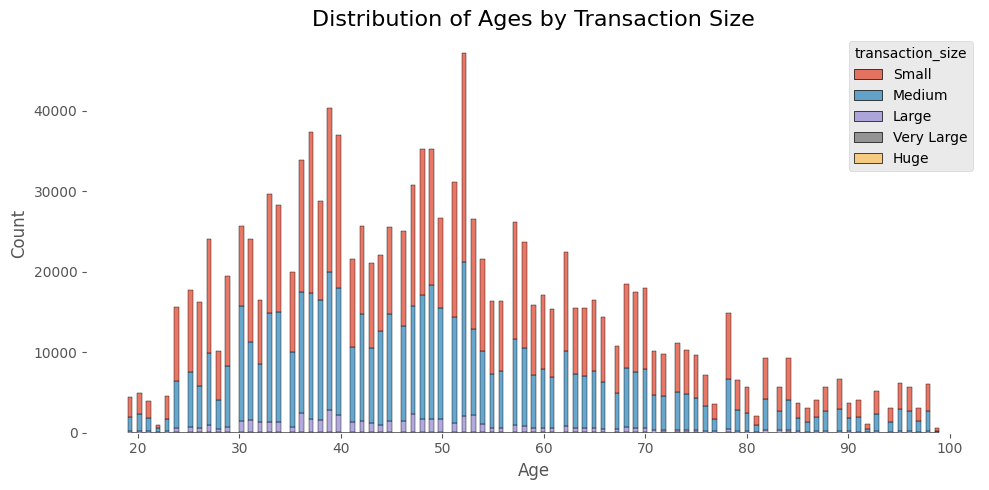

In [23]:
plt.style.use('ggplot')
# Plot
plt.figure(figsize=(10, 5))

sns.histplot(data=df, x='age', multiple='stack', hue='transaction_size', edgecolor='k')

plt.title('Distribution of Ages by Transaction Size', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.gca().set_facecolor('white') 
plt.tight_layout()

plt.show()

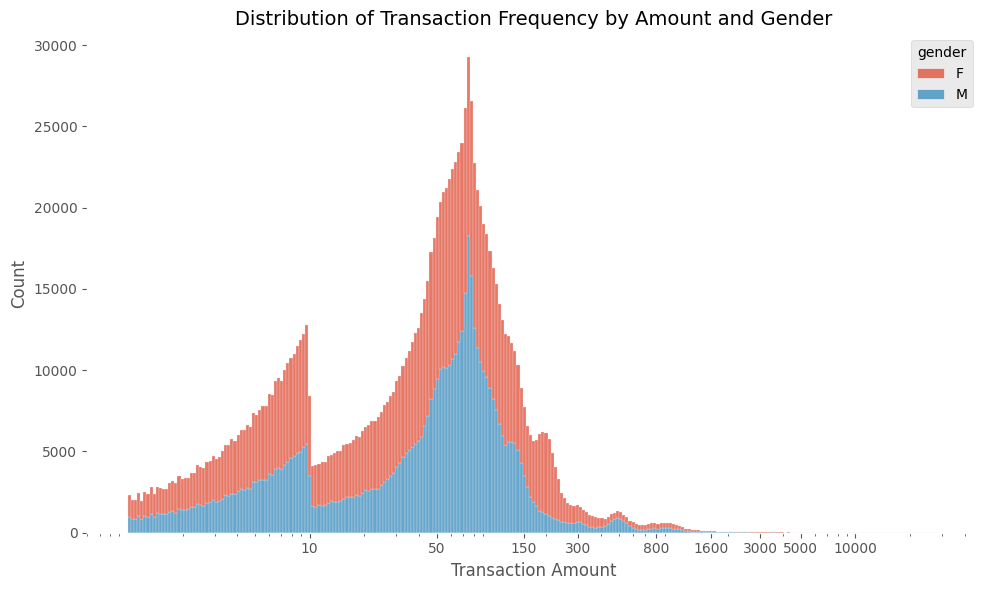

In [24]:
import matplotlib as mpl
f, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=df, x='amt', hue='gender', multiple='stack', log_scale=True)

ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 50, 150, 300, 800, 1600, 3000, 5000, 10000])
ax.set_xticklabels(['10', '50', '150', '300', '800', '1600', '3000', '5000', '10000'])
ax.set_xlabel('Transaction Amount', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Transaction Frequency by Amount and Gender', fontsize=14)
ax.set_facecolor('white') 
ax.grid(False)

plt.tight_layout()
plt.show()

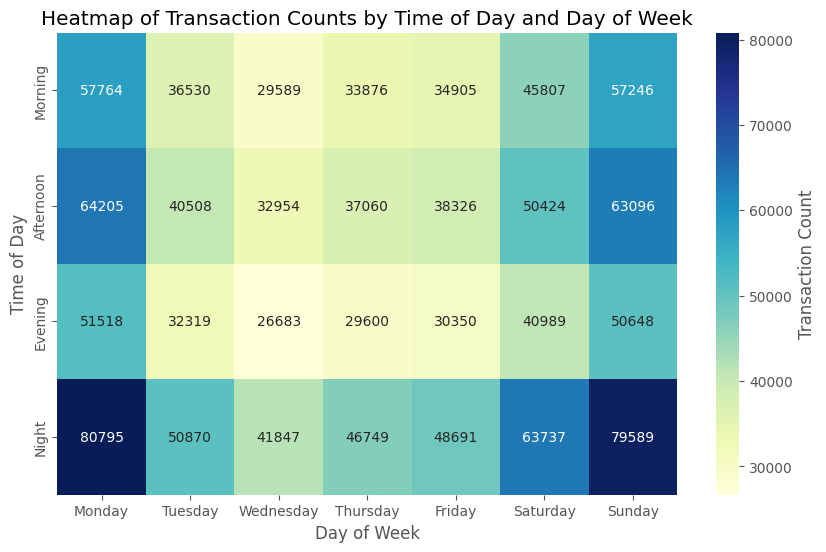

In [25]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_name'] = pd.Categorical(df['day_name'], categories=days_order, ordered=True)

time_of_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df['time_of_day'] = pd.Categorical(df['time_of_day'], categories=time_of_day_order, ordered=True)

heatmap_data = df.pivot_table(values='amt', index='time_of_day', columns='day_name', aggfunc='count')

# Plot 
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.0f', cbar_kws={'label': 'Transaction Count'})

plt.title('Heatmap of Transaction Counts by Time of Day and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.show()

In [26]:
df = df.drop(columns=['user_id', 'name', 'age', 'job', 'city', 'state', 'year', 'lat', 'long', 'hour', 'day', 'month', 'log_amt', 'merchant', 'amt'])

In [27]:
df = pd.get_dummies(df,columns=['day_name', 'time_of_day', 'age_group', 'gender', 'season', 'category', 'transaction_size'])

In [28]:
df.head()

,merch_lat,merch_long,is_fraud,day_name_Monday,day_name_Tuesday,day_name_Wednesday,day_name_Thursday,day_name_Friday,day_name_Saturday,day_name_Sunday,...,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,transaction_size_Small,transaction_size_Medium,transaction_size_Large,transaction_size_Very Large,transaction_size_Huge
0,36.01,-82.05,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,49.16,-118.19,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,43.15,-112.15,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,47.03,-112.56,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,38.67,-78.63,0,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False


In [29]:
scaler = StandardScaler()

df[['merch_lat', 'merch_long']] = scaler.fit_transform(df[['merch_lat', 'merch_long']])
df.sample(7)

,merch_lat,merch_long,is_fraud,day_name_Monday,day_name_Tuesday,day_name_Wednesday,day_name_Thursday,day_name_Friday,day_name_Saturday,day_name_Sunday,...,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,transaction_size_Small,transaction_size_Medium,transaction_size_Large,transaction_size_Very Large,transaction_size_Huge
313531,-0.51,-1.11,0,False,False,False,False,True,False,False,...,False,False,False,False,True,True,False,False,False,False
1198929,-1.72,-0.36,0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
110556,-0.10,1.08,0,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1133166,0.65,0.50,0,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
1104866,1.11,-0.13,0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
547116,-1.58,-0.00,0,False,False,False,True,False,False,False,...,False,False,False,False,True,True,False,False,False,False
900593,0.66,0.75,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


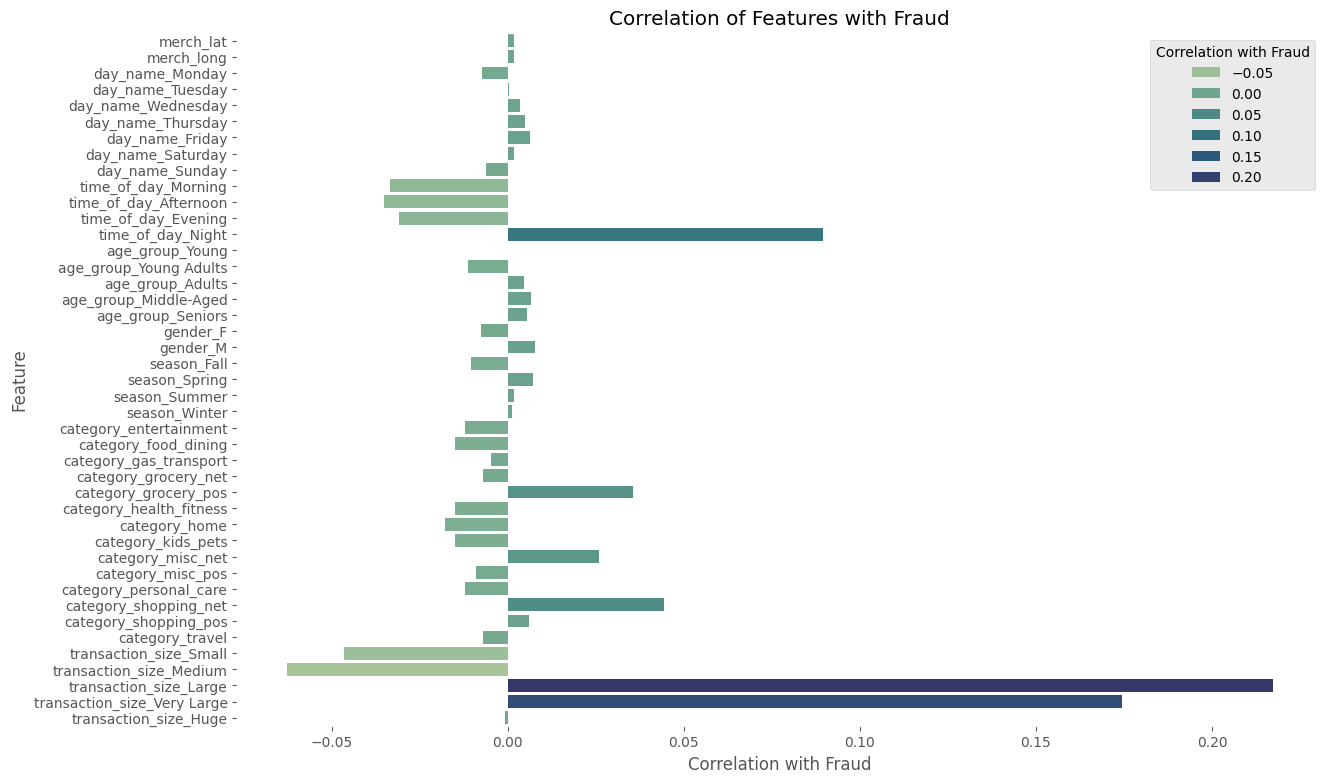

In [30]:
correlation_matrix = df.corr()

# Correlation with the target variable 'is_fraud'
correlation_with_target = correlation_matrix['is_fraud']

correlation_with_target_df = correlation_with_target.drop(['is_fraud']).reset_index()
correlation_with_target_df.columns = ['Feature', 'Correlation with Fraud']

# Plot
plt.figure(figsize=(14, 9))
sns.barplot(x='Correlation with Fraud', y='Feature', hue='Correlation with Fraud', data=correlation_with_target_df, palette='crest')
plt.gca().set_facecolor('white') 
plt.title('Correlation of Features with Fraud')
plt.show()

In [31]:
X = df.drop(columns='is_fraud')
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [32]:
#Initialize the model
model = RandomForestClassifier(random_state=17)

In [33]:
#Randomized Search
param_distributions = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(10, 20),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 2),
    'class_weight': ['balanced', 'balanced_subsample']
}

In [34]:
randomized_search = RandomizedSearchCV(estimator=model, 
                                       param_distributions=param_distributions, 
                                       n_iter=8, cv=2, verbose=1, n_jobs=-1, random_state=17)

In [35]:
sm = SMOTE(random_state=17)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
randomized_search.fit(X_train_sm, y_train_sm)
best_model = randomized_search.best_estimator_
print(f"Best Parameters: {randomized_search.best_params_}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 117}


In [36]:
y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[375030  11744]
 [   388   1841]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    386774
           1       0.14      0.83      0.23      2229

    accuracy                           0.97    389003
   macro avg       0.57      0.90      0.61    389003
weighted avg       0.99      0.97      0.98    389003



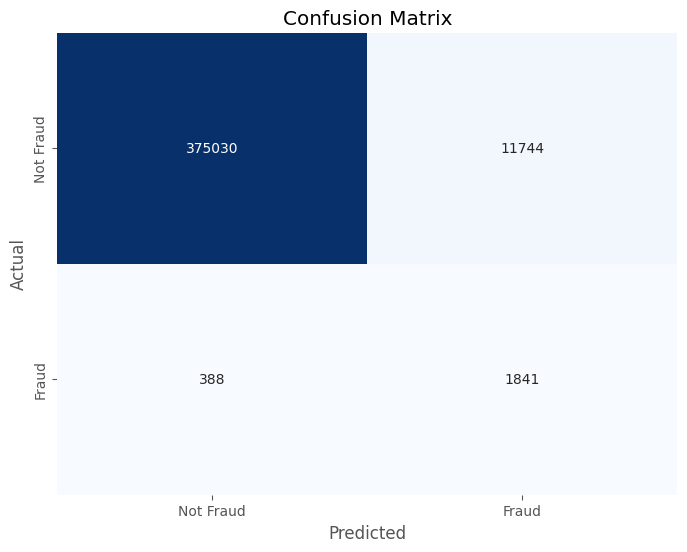

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()